### Deep Learning Supervised Text Classification
- BiLSTM (baseline data augmentation, i.e., standard methods)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime


### Load Data

In [73]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031323', #'ppe non-compliance'
    '2210032046'  # mechanical or equipment issue
]

fn_aug_names = [
    'hydraulic fluid or oil leak_4700_simple_da',
    'line strike_8091_simple_da',
    'site compliance or practice issue_8000_simple_da',
    'ppe non-compliance_8050_simple_da',
    'mechanical or equipment issue_8294_simple_da'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: line strike


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


## Prepare Base Data (Train / Test Splits)

In [74]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify=y)

In [75]:
base_train_count = len(X_train)
base_train_count

75085

In [76]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 65 [289, 333, 511, 871, 999, 1582, 1621, 1681, 1779, 1786, 1952, 3016, 3661, 3701, 4061, 5541, 5974, 6243, 7850, 8079, 8922, 9151, 9378, 9415, 9477, 9655, 9703, 10244, 10685, 11586, 11711, 12444, 12798, 13607, 15441, 15688, 16445, 17477, 17811, 17821, 18900, 19951, 20317, 20420, 20911, 21007, 21145, 21933, 22636, 22913, 23835, 23880, 24390, 24588, 26371, 26529, 33803, 42099, 44140, 55717, 68572, 72807, 74150, 75652, 84218]
Train: 261 [285, 791, 819, 824, 1252, 1334, 1361, 1559, 1610, 1675, 1677, 1746, 1755, 1798, 1804, 1971, 1984, 2025, 2033, 2042, 2067, 2070, 2168, 2210, 2243, 2276, 2303, 2337, 2377, 2457, 2492, 2546, 2557, 2614, 2617, 2674, 3046, 3114, 3180, 3355, 3357, 3381, 3434, 3469, 3471, 3497, 3579, 3609, 3644, 3688, 3706, 3777, 3974, 3997, 4141, 4435, 4535, 4636, 4757, 4910, 5068, 5158, 5359, 5470, 5510, 5576, 5610, 5631, 5670, 5820, 5999, 6114, 6501, 6704, 7729, 7736, 7905, 8019, 8031, 8033, 8081, 8102, 8185, 8255, 8359, 8425, 8504, 8556, 8746, 8792, 8912, 8918, 8986, 9

In [77]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues

,text,category
285,dc cable struck allied fencing employees repor...,1
791,it was notice that part of the bank had collap...,1
819,plate compactor was damaged when operator turn...,1
824,excavator made contact with two empty one inch...,1
1252,as the equipment operator began to dig into th...,1
...,...,...
86830,contact with hot objects or substances a contr...,1
89205,direct exposure to electricity greater than tw...,1
91291,indirect exposure to electricity unspecified a...,1
92988,direct exposure to electricity unspecified emp...,1


## Augment Data using Basic Data Augmentation (BDA)

In [78]:
fn_aug_names

['hydraulic fluid or oil leak_4700_simple_da',
 'line strike_8091_simple_da',
 'site compliance or practice issue_8000_simple_da',
 'ppe non-compliance_8050_simple_da',
 'mechanical or equipment issue_8294_simple_da']

In [79]:
# Load fabricated reports
fn_name = fn_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_name}.csv')
print(f"Printing sample for '{fn_name}'")
df_fab.sample(10)

Printing sample for 'line strike_8091_simple_da'


,text,category
6007,line strikenon active fiber line conducting ex...,1
1021,an unmarked unknown line was struck with minim...,1
1500,marked line strike no injuries sustained incid...,1
2810,excavator find out operator damage a push down...,1
2512,contact was made to foursome inch hdpe potable...,1
6948,a handrail on a slip steer was damaged when it...,1
5951,skid steer struck electrical rating box causin...,1
5003,vertically rigged pipe slipped through rigging...,1
5543,low voltage cable was cable by a three hundred...,1
4027,hit a live natural gasconade line operator was...,1


In [80]:
# Prepare data & conbine with original training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

# Complete the new training dataframe
df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,pedestrian vehicular incident unspecified a pa...,0
1,fall from collapsing structure or equipment le...,0
2,fa veolia walters foreign body left eye ks2017...,0
3,injury by other personunintentional or intent ...,0
4,worker is weak and lost balance while placing ...,0
...,...,...
83171,direct exposure to electricity greater than tw...,1
83172,direct exposure to electricity greater than tw...,1
83173,exposure to electricity greater than two hundr...,1
83174,point exposure to electricity greater than two...,1


In [81]:
# Shuffle the dataframe
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,caught in running equipment or machinery n e c...,0
1,worker was tested positive after swab test on ...,0
2,fall on same level due to slipping an employee...,0
3,ip has seizure while working ip started having...,0
4,damaged and cut communicating lines employee w...,1
...,...,...
83171,exposure to environmental heat an employee had...,0
83172,fall through surface or existing opening unspe...,0
83173,struck water line operator was drilling forty ...,1
83174,preventable company vehicle minor damage no in...,0


In [82]:
# Visually/verify a random sample of 20 (hits)
df_tmp[df_tmp['category']==1].sample(20)

,text,category
80339,place one twelve pvc abandonded line was struc...,1
72028,cable strike a three hundred and sixty excavat...,1
52642,a piece of eight on as to staged area pipe may...,1
54772,hit country a live natural gas line operator w...,1
77882,struck by dislodged flying physical object par...,1
8575,water vehicle incident unspecified an employee...,1
49460,nonroadway collision object other than n e c a...,1
33099,buried power line stike car and hsse personnel...,1
49940,redundant cable tray dislodged and struck empl...,1
46999,during piling operations during piling atomic ...,1


## Build Model

In [63]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    # input_length=MAX_LEN, input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIMS
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [83]:
X_train = df_tmp.text
y_train = df_tmp.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


Note: Skip to model build (next code block) if you are going to load a previoud model.

In [84]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 61542
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 50)           3077150   
                                                                 
 bidirectional_12 (Bidirecti  (None, 500, 64)          21248     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 500, 64)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 500, 64)          24832     
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 500, 64)           0         
                                                                 
 bidirectional_14 (Bidire

In [85]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

55717    contact with objects and equipment unspecified...
17811    track hoe struck exposed nonenergized one thou...
18900    two lines were struck by trackhoe digging for ...
11586    subcontractors contacted four subcontractor em...
6243     unmarked line strike incident 30827our crewstr...
                               ...                        
21145    skid steer operator was backfilling a temp pow...
19951    flat tire employee was preparing to put spare ...
33803    indirect exposure to electricity greater than ...
1952     a small low pressure water pipe sustained a sm...
21933    skid steer operator bucket made contact and da...
Name: text, Length: 65, dtype: object

In [86]:
Counter(y_test)

Counter({0: 18707, 1: 65})

In [87]:
Counter(y_train)

Counter({0: 74824, 1: 8352})

In [88]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 7517
Number of positives in validation data: 835


Train new model (n) or load existing (l):n
Training for: line strike
Enter epoch number (default is 3): 3
Epoch 1/3
585/585 [==============================] - 1816s 3s/step - loss: 0.1130 - categorical_accuracy: 0.9101 - val_loss: 0.0834 - val_categorical_accuracy: 0.9120
Epoch 2/3
585/585 [==============================] - 1786s 3s/step - loss: 0.0217 - categorical_accuracy: 0.8971 - val_loss: 0.0112 - val_categorical_accuracy: 0.8988
Epoch 3/3
585/585 [==============================] - 1790s 3s/step - loss: 0.0093 - categorical_accuracy: 0.8986 - val_loss: 0.0125 - val_categorical_accuracy: 0.8952


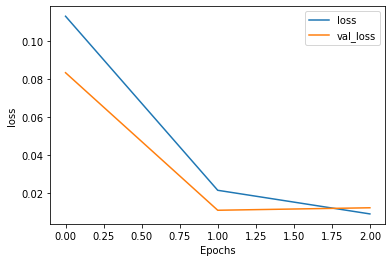

In [89]:
train_or_load = input('Train new model (n) or load existing (l):')
if train_or_load == 'n':
    # Train the model
    print('Training for:', focus_cat)
    epoch_num = int(input('Enter epoch number (default is 3): '))
    history = model.fit(X_train_vGlove, y_vtrain,
                                validation_data=(X_val_Glove, y_val),
                                epochs=epoch_num,
                                batch_size=128,
                                verbose=1)
    
    # Plot training history
    plot_graphs(history, 'loss')
else:
    # load the model from disk
    fname = input('Specify filename (without extension):')
    filename = f'08_output/models/{fname}.pkl'
    model = pickle.load(open(filename, 'rb'))

In [90]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}" with {epoch_num} epochs ... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model for "line strike" with 3 epochs ... 

587/587 [==============================] - 232s 393ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18707
           1       0.24      0.45      0.31        65

    accuracy                           0.99     18772
   macro avg       0.62      0.72      0.66     18772
weighted avg       1.00      0.99      0.99     18772





In [ ]:
focus_cat

'line strike'

In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  65


In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_bda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

NameError: ignored

In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

In [91]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_bda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))